In [1]:
%matplotlib inline

import numpy as np

from numpy.random import choice, normal

import matplotlib.pyplot as plt
import matplotlib.dates as md

from itertools import cycle

import pds4_tools as pds
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from scipy.stats import median_absolute_deviation as mad

from local_utils import *

str2date = lambda x: datetime.strptime(x, '00133M%H:%M:%S.%f')
str2dates = lambda xs: [str2date(xs[i]) for i in range(len(xs))]

# print(str2date('00133M00:00:28.824').microsecond)
print(str2dates(['00133M00:00:28.824', '00133M00:00:29.311', '00133M00:00:29.797']))

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

kappa = 0.4

[datetime.datetime(1900, 1, 1, 0, 0, 28, 824000), datetime.datetime(1900, 1, 1, 0, 0, 29, 311000), datetime.datetime(1900, 1, 1, 0, 0, 29, 797000)]


In [2]:
def calculate_scaled_windspeed(windspeeds_to_scale, z, zstar, z0=150.):
    """
    Returns wind speed time series scaled as if it were measured at a different elevation,
    assuming a logarithmic wind profile
    
    Args:
        windspeeds_to_scale (float array): wind speeds to scale
        z (float): altitude at which measurement is assumed to take place
        zstar (float): the roughness scale - https://en.wikipedia.org/wiki/Roughness_length
        z0 (float, optional): altitude at which actual wind speed measurement was made; defaults to 1.5 meters
        kappa (float, optional): von Karman parameter; defaults to 0.4
    
    Returns:
        Scaled wind speed time series
    
    """
    
    # Calculate ustar assuming average windspeeds_to_scale
    return windspeeds_to_scale*np.log(z/zstar)/np.log(z0/zstar)

def retrieve_relevant_times(time, t0, sample_time):
    return (t0 <= time) & (time <= t0 + sample_time)

def sample_wind_profile(sample_time, t0, time, windspeeds, heights):
    """
    Return wind speeds from four height sampled over the given sample time
    
    Args:
        sample_time (float): time over which to average in seconds
        t0 (float, optional): time at which at start averages
        times (float array): measured times
        windspeeds (dict of float arrays): wind speed time-series referenced by anemometer height
    
    Returns:
        Wind speeds averaged for sample time from different anemometer times series, one after another
    """
    
    # Run through each height, assuming the first one in windspeeds is the lowest and on up
    cur_t0 = t0
    
    averaged_windspeeds = np.zeros_like(heights)
    std_windspeeds = np.zeros_like(heights)
    for i in range(len(heights)):
        ind = retrieve_relevant_times(time, t0, sample_time) 
        
        averaged_windspeeds[i] = np.mean(windspeeds[str(heights[i])][ind])
        std_windspeeds[i] = np.std(windspeeds[str(heights[i])][ind])/\
            (np.sqrt(len(windspeeds[str(heights[i])][ind]) - 1.))
        
#         std_windspeeds[i] = 1.4826*mad(windspeeds[str(heights[i])][ind])/\
#             (np.sqrt(len(windspeeds[str(heights[i])][ind]) - 1.))

        cur_t0 += sample_time
        
    return averaged_windspeeds, std_windspeeds

In [3]:
def calc_num_points(sample_time, sampling):
    return np.floor(sample_time/sampling)

In [4]:
struct_list = pds.read('Mars 2020 Data/WE__0133___________DER_WS__________________P01.xml')
print(struct_list)

Processing label: Mars 2020 Data/WE__0133___________DER_WS__________________P01.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
<StructureList at 0x7fb270090ca0> with:
<HeaderStructure 'HEADER' at 0x7fb27008a9a0>
<TableStructure 'TABLE' at 0x7fb291e30640>


yerr:  [6.84568407 7.21533176 7.68950296 9.52214209]
popt:  [124.70362314 474.40207805]
unc:  [1.25961795 1.43929662]
analytic_unc:  [5.04422419 6.54114632]
rescaled_sigma:  [6.84568407 7.21533176 7.68950296 9.52214209]
rescaled_sigma/saved_ustar:  0.20328603629257957
sigma_zstar/zstar:  0.19040754089889736
sigma_ustar/ustar:  0.038814663562913604
correct sigma_zstar/zstar:  0.11407922155187447
correct sigma_ustar/ustar:  0.010100892970469774


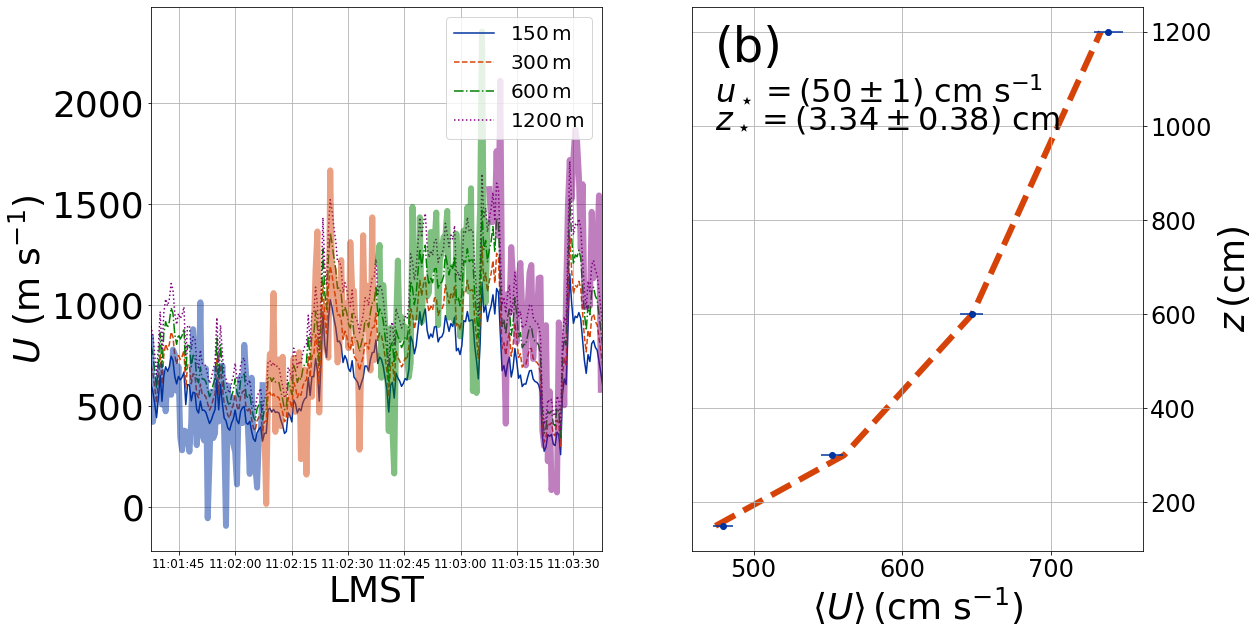

In [5]:
# struct_list.info()
# print(len(struct_list['TABLE']['HORIZONTAL_WIND_SPEED']))

colors = cycle([BoiseState_blue, BoiseState_orange, "green", "purple"])
linestyles = cycle(['solid', 'dashed', 'dashdot', 'dotted'])

time = np.array(str2dates(struct_list['TABLE']['LMST']))
# Prepare to add some noise
ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999)
sigma = np.std(struct_list['TABLE']['HORIZONTAL_WIND_SPEED'][ind])*100

ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999) &\
        (time > datetime(1900, 1, 1, 11, 0, 0)) & (time < datetime(1900, 1, 1, 12, 0, 0))
time = time[ind]

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

zs = np.array([150., 300., 600., 1200.]) # cm
delta_x = np.log(2)
saved_zstar = 2. # 2 cm
saved_ustar = kappa*np.mean(struct_list['TABLE']['HORIZONTAL_WIND_SPEED'][ind]*100)/np.log(zs[0]/saved_zstar)

scaled_windspeeds = {}
noisy_scaled_windspeeds = {}

for i in range(len(zs)):
    color = next(colors)
    ls = next(linestyles)
    
    scaled_windspeeds[str(zs[i])] =\
        calculate_scaled_windspeed(struct_list['TABLE']['HORIZONTAL_WIND_SPEED'][ind]*100, zs[i], saved_zstar, 
                                  z0=np.min(zs))
    
    # And add in the noise
    noisy_scaled_windspeeds[str(zs[i])] = scaled_windspeeds[str(zs[i])] +\
        normal(scale=sigma, size=len(scaled_windspeeds[str(zs[i])]))

    ax1.plot(time, scaled_windspeeds[str(zs[i])], color=color, ls=ls, label=r'$%g\, {\rm m}$' % zs[i])
        
xfmt = md.DateFormatter('%H:%M:%S')
ax1.xaxis.set_major_formatter(xfmt)
ax1.grid(True)
ax1.tick_params(axis="x", labelsize=12)
ax1.tick_params(axis="y", labelsize=36)
ax1.set_xlabel("LMST", fontsize=36)
ax1.set_ylabel(r'$U\ \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax1.legend(loc='upper right', fontsize=20)
ax1.set_xlim([np.min(time), np.min(time) + timedelta(minutes=2)])

### Synthetic wind profile ###

t0 = np.min(time)
sample_time = timedelta(seconds=30.)

cur_t0 = t0
ind = retrieve_relevant_times(time, cur_t0, sample_time)
cur_color = next(colors)
ax1.plot(time[ind], noisy_scaled_windspeeds[str(zs[0])][ind], lw=6, color=cur_color, alpha=0.5)

cur_t0 += sample_time
ind = retrieve_relevant_times(time, cur_t0, sample_time)
cur_color = next(colors)
ax1.plot(time[ind], noisy_scaled_windspeeds[str(zs[1])][ind], lw=6, color=cur_color, alpha=0.5)

cur_t0 += sample_time
ind = retrieve_relevant_times(time, cur_t0, sample_time)
cur_color = next(colors)
ax1.plot(time[ind], noisy_scaled_windspeeds[str(zs[2])][ind], lw=6, color=cur_color, alpha=0.5)

cur_t0 += sample_time
ind = retrieve_relevant_times(time, cur_t0, sample_time)
cur_color = next(colors)
ax1.plot(time[ind], noisy_scaled_windspeeds[str(zs[3])][ind], lw=6, color=cur_color, alpha=0.5)

averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, noisy_scaled_windspeeds, zs)
# ax2.errorbar(averaged_windspeeds, zs, xerr=std_windspeeds, marker='o', color=BoiseState_blue, ls='')

# Law-of-the-Wall fit
y = averaged_windspeeds
log_z = np.log(zs/np.min(zs))
yerr = std_windspeeds
popt, pcov = curve_fit(lin_fit, log_z, y, sigma=yerr)
unc = np.sqrt(np.diag(pcov))
unc *= np.sqrt(chisqg(y, np.polyval(popt, log_z), sd=yerr)/(len(zs) - 2))
yerr *= np.sqrt(chisqg(y, np.polyval(popt, log_z), sd=yerr)/(len(zs) - 2))
print("yerr: ", yerr)

analytic_unc = np.array([calc_analytic_sigma_slope(delta_x, np.mean(yerr), len(zs)), 
                         calc_analytic_sigma_intercept(np.mean(yerr), len(zs))])

print("popt: ", popt)
print("unc: ", unc)
print("analytic_unc: ", analytic_unc)

ax2.errorbar(averaged_windspeeds, zs, 
             xerr=std_windspeeds*np.sqrt(chisqg(y, np.polyval(popt, log_z), sd=yerr)/(len(zs) - 2)), 
             marker='o', color=BoiseState_blue, ls='')

# Re-scale uncertainties
rescaled_sigma = rescale_sigma(averaged_windspeeds, np.polyval(popt, log_z), np.mean(yerr))
# rescaled_sigma = np.mean(std_windspeeds)

ustar = calc_ustar_from_slope(kappa, popt[0])
zstar = calc_zstar_from_slope_and_intercept(np.min(zs), popt[0], popt[1])
print("rescaled_sigma: ", std_windspeeds)
print("rescaled_sigma/saved_ustar: ", rescaled_sigma/saved_ustar)
sigma_ustar = calc_analytic_sigma_ustar(delta_x, rescaled_sigma, len(zs))
sigma_zstar = calc_analytic_sigma_zstar(np.min(zs), popt[0], popt[1], delta_x, rescaled_sigma, len(zs))

print("sigma_zstar/zstar: ", sigma_zstar/zstar)
print("sigma_ustar/ustar: ", sigma_ustar/ustar)

sigma_ustar = 0.4*unc[0]
sigma_zstar = zstar*popt[1]/popt[0]*np.sqrt((unc[0]/popt[0])**2 + (unc[1]/popt[1])**2 - 2*pcov[1,0]/popt[0]/popt[1])

print("correct sigma_zstar/zstar: ", sigma_zstar/zstar)
print("correct sigma_ustar/ustar: ", sigma_ustar/ustar)

# print(saved_zstar, saved_ustar)
# print(zstar, sigma_zstar, np.abs(saved_zstar - zstar)/sigma_zstar)
# print(ustar, sigma_ustar, np.abs(saved_ustar - ustar)/sigma_ustar)

ax2.plot(np.polyval(popt, log_z), zs, lw=6, color=BoiseState_orange, ls='--', zorder=-1)
ax2.text(0.05, 0.90, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.text(0.05, 0.825, r'$u_\star = \left( %.0f\pm%.0f \right)\ {\rm cm\ s^{-1}}$' % (ustar, sigma_ustar), 
         fontsize=32, transform=ax2.transAxes)
ax2.text(0.05, 0.775, r'$z_\star = \left( %.2f\pm%.2f \right)\ {\rm cm}$' % (zstar, sigma_zstar), 
         fontsize=32, transform=ax2.transAxes)

ax2.grid(True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.tick_params(labelsize=24)
ax2.set_xlabel(r'$\langle U \rangle \, \left( {\rm cm\ s^{-1} } \right)$', fontsize=36)
ax2.set_ylabel(r'$z\, \left( {\rm cm } \right)$', fontsize=36)
ax2.grid(True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# print(zs)
# print(averaged_windspeeds)
# print(std_windspeeds)

# fig.savefig("Martian_Windspeeds.jpg", dpi=300, bbox_inches="tight")

In [28]:
fig = plt.figure(figsize=(10*16/9, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)
num_sample_times = 70
sample_times = [timedelta(seconds=2*(i + 1)) for i in range(num_sample_times)]

num_tries = 100

median_quantile = 0.5
upper_quantile = 0.84
lower_quantile = 0.16

# saved_sample_times = np.array([])

# zstars = np.array([])
# lower_zstar_sigmas = np.array([])
# upper_zstar_sigmas = np.array([])

# ustars = np.array([])
# lower_ustar_sigmas = np.array([])
# upper_ustar_sigmas = np.array([])

# # Save the mean scatter
# stds = np.array([])

# for i in range(len(sample_times)):
#     cur_zstars = np.array([])
#     cur_ustars = np.array([])
#     cur_stds = np.array([])
    
#     for j in range(num_tries):
        
#         # Generate new random noisy data    

#         # Make sure there is plenty of time at the end
#         t0 = choice(time[time < time[-1] - sample_times[i]])
        
#         averaged_windspeeds, std_windspeeds =\
#             sample_wind_profile(sample_times[i], t0, time, noisy_scaled_windspeeds, zs)
    
#         # How about we toss any profile that doesn't increase with altitude?
#         # https://stackoverflow.com/questions/3755136/pythonic-way-to-check-if-a-list-is-sorted-or-not
#         if(all(averaged_windspeeds[i+1] >= averaged_windspeeds[i] for i in range(len(averaged_windspeeds) - 1))):
    
#             x = np.log(zs/np.min(zs))
#             y = averaged_windspeeds
#             popt, pcov = curve_fit(lin_fit, x, y, sigma=std_windspeeds)
#             unc = np.sqrt(np.diag(pcov))

#             # If the slope is negative, then we want zstar to be negative.    
#             zstar = calc_zstar_from_slope_and_intercept(np.min(zs), *popt)
#             cur_zstars = np.append(zstar, cur_zstars)
            
#             ustar = calc_ustar_from_slope(kappa, popt[0])
#             cur_ustars = np.append(ustar, cur_ustars)
            
#             cur_stds = np.append(std_windspeeds, cur_stds)
            
#     zstars = np.append(np.quantile(cur_zstars, [median_quantile]), zstars)
#     lower_sigma, upper_sigma = np.quantile(cur_zstars, [lower_quantile, upper_quantile]) -\
#         np.quantile(cur_zstars, [median_quantile])
#     lower_zstar_sigmas = np.append(-lower_sigma, lower_zstar_sigmas)
#     upper_zstar_sigmas = np.append(upper_sigma, upper_zstar_sigmas)

#     ustars = np.append(np.quantile(cur_ustars, [median_quantile]), ustars)
#     lower_sigma, upper_sigma = np.quantile(cur_ustars, [lower_quantile, upper_quantile]) -\
#         np.quantile(cur_ustars, [median_quantile])
#     lower_ustar_sigmas = np.append(-lower_sigma, lower_ustar_sigmas)
#     upper_ustar_sigmas = np.append(upper_sigma, upper_ustar_sigmas)
    
#     saved_sample_times = np.append(sample_times[i].seconds, saved_sample_times)
    
#     stds = np.append(np.mean(cur_stds), stds)

ax1.plot(saved_sample_times, zstars, color=BoiseState_blue, lw=3)
ax1.fill_between(saved_sample_times, zstars - lower_zstar_sigmas, 
                zstars + upper_zstar_sigmas, color=BoiseState_blue, alpha=0.5)

# print(saved_sample_times)
# print(zstars)
ax1.axhline(saved_zstar, color=BoiseState_orange)
# ax1.fill_between(saved_sample_times, saved_zstar + saved_sigma_zstar, saved_zstar - saved_sigma_zstar, 
#                 color=BoiseState_orange, alpha=0.25)

ax1.set_ylabel(r'$z_\star\, \left({\rm cm}\right)$', fontsize=36)
ax1.set_ylim([0, 20])
ax1.set_xlim([2, 60])
ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.text(0.9, 0.8, "(a)", fontsize=64, transform=ax1.transAxes)

ax2.plot(saved_sample_times, ustars, color=BoiseState_blue, lw=3)
ax2.fill_between(saved_sample_times, ustars - lower_ustar_sigmas, 
                ustars + upper_ustar_sigmas, color=BoiseState_blue, alpha=0.5)

ax2.axhline(saved_ustar, color=BoiseState_orange)
# ax2.fill_between(saved_sample_times, saved_ustar + saved_sigma_ustar, saved_ustar - saved_sigma_ustar, 
#                 color=BoiseState_orange, alpha=0.25)

ax2.set_xlabel("Averaging Window (sec)", fontsize=36)
ax2.set_ylabel(r'$u_\star\, \left({\rm cm\ s^{-1}}\right)$', fontsize=36)
ax2.set_ylim([20, 100])
ax2.tick_params(labelsize=24)
ax2.grid(True)
ax2.text(0.9, 0.8, "(b)", fontsize=64, transform=ax2.transAxes)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.tight_layout()

### Add analytic errors ###
sampling = (time[1] - time[0]).microseconds/1e6
num_points = calc_num_points(saved_sample_times, sampling)
scaled_sigma_over_ustar = stds/saved_ustar

sigma_zstars = calc_analytic_fractional_zstar_uncertainty(len(zs), 
      sigma_over_ustar=scaled_sigma_over_ustar, z0_over_zstar=np.min(zs)/saved_zstar)*zstars
ax1.plot(saved_sample_times, sigma_zstars + zstars, color='k', lw=3, ls='--')

# Trying another approach
slope = saved_ustar/kappa
sigma_slope = calc_analytic_sigma_slope(delta_x, stds, len(zs))
intercept = -saved_ustar/kappa*np.log(np.min(zs)/saved_zstar)
sigma_intercept = calc_sigma_intercept_slope(delta_x, stds, len(zs))
sigma_ustars = np.sqrt((sigma_slope/slope)**2*saved_ustar + (sigma_intercept/intercept)**2)*saved_ustar

# sigma_ustars = calc_analytic_fractional_ustar_uncertainty(len(zs), 
#         sigma_over_ustar=scaled_sigma_over_ustar)*ustars
ax2.plot(saved_sample_times, sigma_ustars + saved_ustar, color='k', lw=3, ls='--')
# fig.savefig("synthetic_martian_wind_profile.jpg", dpi=300, bbox_inches="tight")

SyntaxError: unmatched ')' (585442549.py, line 124)

[-0.42406423  2.16562316]


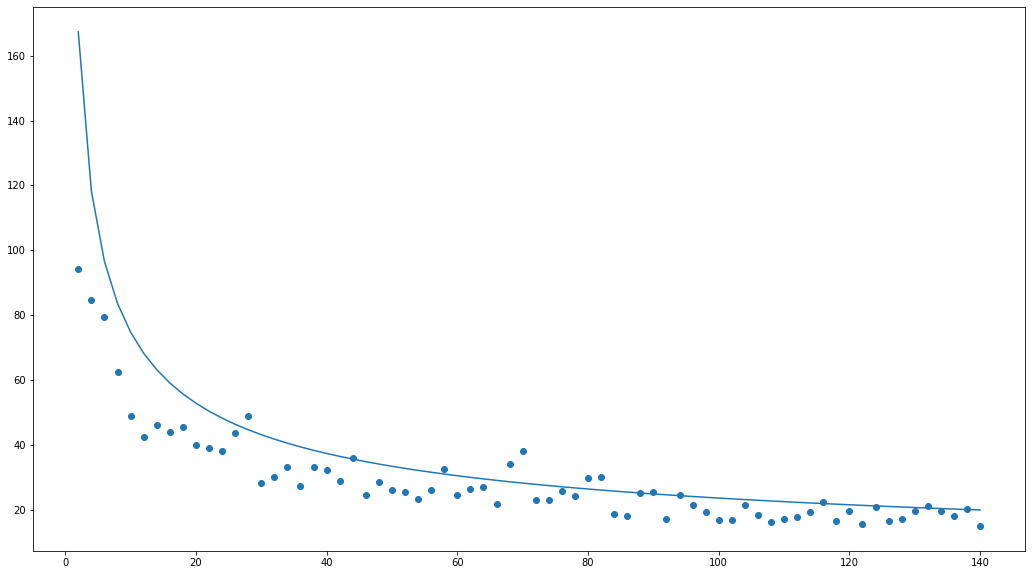

In [67]:
# Exploring the dependence of the error of the mean with number of points in the wind profiles

fig = plt.figure(figsize=(10*16/9, 10))
ax1 = fig.add_subplot(111)
num_sample_times = 70
sample_times = [timedelta(seconds=2*(i + 1)) for i in range(num_sample_times)]

num_tries = 100

# saved_sample_times = np.array([])
# stds = np.array([])

# for i in range(len(sample_times)):
#     for j in range(num_tries):
#         cur_stds = np.array([])
#         # Generate new random noisy data    

#         # Make sure there is plenty of time at the end
#         t0 = choice(time[time < time[-1] - sample_times[i]])
        
#         averaged_windspeeds, std_windspeeds =\
#             sample_wind_profile(sample_times[i], t0, time, noisy_scaled_windspeeds, zs)
#         cur_stds = np.append(np.mean(std_windspeeds), cur_stds)
    
#     stds = np.append(np.mean(cur_stds), stds)
#     saved_sample_times = np.append(sample_times[i].seconds, saved_sample_times)
            
ax1.scatter(saved_sample_times, stds)
ax1.plot(saved_sample_times, 20.*np.sqrt(saved_sample_times[0])/np.sqrt(saved_sample_times))

popt, pcov = np.polyfit(np.log10(saved_sample_times), np.log10(stds), 1, cov=True)
print(popt)